### From SAV to LOVE

# HW №4

## Введение в обработку естественного языка
### Тематическое моделирование. EM-алгоритм
### Практическое задание

**Взять ноутбук с семинара и проанализировать другие тематики**  
<li>количество тематик от 3-х и более</li>
<li>попробуйте выявить оптимальное количество тем и вывести сами тематики</li>
<li>сравните и сделайте выводы, реализаций gensim/bigartm и ещё возьмите sklearn реализацию метода LDA</li>

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings('ignore')
import os
import time

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Построим тематические модели для корпуса новостей Lenta.ru, с которым мы уже работали ранее.

In [96]:
# !wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [97]:
# !pip install corus

In [8]:
from corus import load_lenta

path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [9]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]

In [10]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])

In [11]:
data.sample(3)

,title,topic,text,tags
672840,"Израильтяне покинули Бейт Ханун, но пообещали вернуться",Мир,"Израильские военнослужащие и бронетехника покинули город Бейт Ханун, расположенный в секторе Газа, сообщает BBC News. Войска вошли в этот город в воскресенье в рамках целой серии операций в секторе Газа, целью которой, как утверждали военные, было разрушение террористической инфраструктуры. Изра...",Все
503305,Потерявшим работу чиновникам дадут денег на собственный бизнес,Экономика,"Чиновникам, потерявшим работу из-за сокращения числа проверок малого бизнеса, предлагается выделять гранты на открытие собственного бизнеса. Об инициативе директора департамента госрегулирования в экономике Минэкономразвития Андрея Шарова сообщает газета ""Коммерсант"". Напомним, 2 июля российское...",Все
185195,IBM превратила суперкомпьютер в литредактора,Наука и техника,"Компания IBM разработала приложение c функциями литредактора Tone Analyzer для суперкомпьютера Watson, сообщает портал Endgadget. Машина оценивает эмоциональную тональность предлагаемого ей текста, анализируя отдельные слова. По итогам проверки она подсказывает синонимы, способные повлиять на об...",Игры


In [12]:
len(data)

739350

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739350 entries, 0 to 739349
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   739350 non-null  object
 1   topic   739350 non-null  object
 2   text    739350 non-null  object
 3   tags    739350 non-null  object
dtypes: object(4)
memory usage: 22.6+ MB


In [14]:
data.topic.value_counts().head(15)

Россия               160518
Мир                  136680
Экономика             79538
Спорт                 64421
Культура              53803
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44675
Из жизни              27611
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Name: topic, dtype: int64

In [15]:
topics = ['Россия', 'Мир', 'Экономика', 'Наука и техника', 
          'Интернет и СМИ', 'Бизнес', 'Путешествия']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)
len(data)

488354

In [16]:
data.isnull().sum()

title    0
topic    0
text     0
tags     0
dtype: int64

### Предобработка| 
Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [98]:
# !pip install pymorphy2

In [20]:
import pymorphy2
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
morph = pymorphy2.MorphAnalyzer()

In [23]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [24]:
data.text.iloc[1]

'С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3\xa0миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выборы в 2016-м. Перед ним поставлена задача выяснить, был ли сговор между штабом 

In [25]:
print(preprocess(data.text.iloc[1]))

['начало', 'расследование', 'российский', 'вмешательство', 'выборы', 'власть', 'сша', 'потратить', 'миллион', 'доллар', 'это', 'сообщать', 'associated', 'press', 'ссылка', 'отчёт', 'министерство', 'юстиция', 'сша', 'документ', 'содержаться', 'дать', 'расход', 'следствие', 'апрель', 'сентябрь', 'год', 'полгода', 'потратить', 'миллион', 'доллар', 'который', 'миллион', 'доллар', 'уйти', 'зарплата', 'сотрудник', 'тысяча', 'поездка', 'сопутствовать', 'расход', 'ранее', 'минюст', 'сша', 'публиковать', 'отчёт', 'затрата', 'дело', 'российский', 'вмешательство', 'предыдущий', 'месяц', 'декабрь', 'расследование', 'спецпрокурор', 'робер', 'мюллер', 'показать', 'малый', 'мера', 'человек', 'окружение', 'президент', 'сша', 'дональд', 'трамп', 'контактировать', 'россиянин', 'время', 'избирательный', 'кампания', 'последующий', 'переходный', 'период', 'вступление', 'должность', 'глава', 'государство', 'мюллер', 'год', 'вести', 'дело', 'якобы', 'российский', 'вмешательство', 'американский', 'выборы', 'п

Ниже мы оставим только случайные 10,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [26]:
data = data.sample(10000)
data.topic.value_counts()

Россия             3259
Мир                2827
Экономика          1680
Наука и техника    1075
Интернет и СМИ      914
Бизнес              136
Путешествия         109
Name: topic, dtype: int64

In [27]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

In [28]:
data['text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags
292924,Албания получила первый транспортный вертолет Cougar,Наука и техника,"[европейский, консорциум, eurocopter, передать, министерство, оборона, албания, первый, средний, военный, транспортный, вертолёт, cougar, сообщать, jane, общий, сложность, страна, должный, поставить, пять, вертолёт, ожидаться, последний, передать, албанский, военный, ведомство, конец, год, церем...",Все
13809,Гроб Маккейна понесет россиянин,Мир,"[публицист, федеральный, координатор, движение, открытый, россия, владимир, кара, мурза, младший, понести, гроб, тело, американский, сенатор, джон, маккейн, траурный, церемония, это, сообщать, politico, данные, газета, политик, попросить, это, россиянин, ещё, апрель, отмечаться, пожелание, макке...",Политика
140571,СМИ раскрыли детали подготовки операции НАТО в Ливии,Мир,"[греция, рамка, подготовка, операция, нато, ливия, закрыть, месяц, свой, воздушный, пространство, самолёт, страна, это, четверг, май, сообщать, риа, новость, ссылка, источник, знакомый, ситуация, собеседник, агентство, заявить, весь, ливийский, борт, закрытый, район, полётный, информация, flight...",Политика


### Модель LDA  
Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [99]:
# !pip install -U gensim

In [31]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [32]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [33]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [34]:
%time  
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, chunksize=50, update_every=1, passes=2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.4 µs


Посмотрим на получившиеся темы:

In [35]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.019*"год" + 0.015*"дело" + 0.012*"который" + 0.012*"суд" + 0.011*"сотрудник" + 0.008*"человек" + 0.008*"задержать" + 0.008*"полиция" + 0.007*"это" + 0.007*"сообщать"'),
 (1,
  '0.029*"год" + 0.015*"новый" + 0.013*"проект" + 0.013*"который" + 0.011*"первый" + 0.010*"система" + 0.010*"игра" + 0.009*"программа" + 0.009*"стать" + 0.008*"также"'),
 (2,
  '0.019*"сша" + 0.015*"страна" + 0.013*"президент" + 0.010*"военный" + 0.009*"заявить" + 0.009*"свой" + 0.009*"американский" + 0.009*"который" + 0.008*"это" + 0.007*"год"'),
 (3,
  '0.019*"который" + 0.011*"это" + 0.010*"мочь" + 0.007*"пользователь" + 0.006*"свой" + 0.006*"учёный" + 0.006*"мир" + 0.006*"интернет" + 0.005*"сайт" + 0.005*"the"'),
 (4,
  '0.037*"год" + 0.030*"процент" + 0.023*"компания" + 0.020*"доллар" + 0.015*"рубль" + 0.015*"миллиард" + 0.014*"миллион" + 0.010*"банк" + 0.010*"это" + 0.008*"россия"'),
 (5,
  '0.018*"россия" + 0.015*"это" + 0.010*"который" + 0.008*"российский" + 0.008*"заявить" + 0.007*"решение" + 0.

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки pyLDAvis. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [40]:
# !pip install pyLDAvis

In [37]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [38]:
print(lda.log_perplexity(corpus))

-7.80991380890764


In [39]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.00040569352282481935


In [41]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.4381466647086105


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

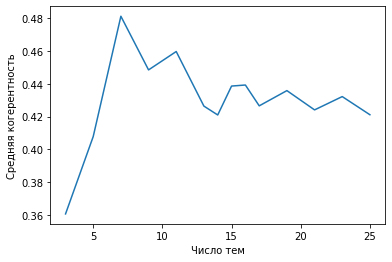

In [45]:
topics_list = [3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 19, 21, 23, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Оптимальное количество тем - 7

Подробнее о метриках для оценки тематических моделей:  
1. [Перплексия](http://qpleple.com/perplexity-to-evaluate-topic-models/)  
2. Когерентность: [один пост](http://qpleple.com/topic-coherence-to-evaluate-topic-models/), [другой пост](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

In [46]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

На другие способы визуализации тематических моделей можно посмотреть [здесь](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#13.-t-SNE-Clustering-Chart).

### Библиотека BigARTM

Теперь попробуем построить модели с помощью библиотеки BigARTM. [Тут](https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb) и [тут](https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb) можно посмотреть на примеры использования библиотеки. 

In [55]:
# !apt-get --yes update
# !apt-get --yes install git make cmake build-essential libboost-all-dev
# !apt-get --yes install python-numpy python-pandas python-scipy
# !wget https://bootstrap.pypa.io/get-pip.py
# !python get-pip.py
# !pip install protobuf tqdm wheel
# !git clone --branch=stable https://github.com/bigartm/bigartm.git

In [59]:
# %cd bigartm

In [60]:
# !mkdir build

In [61]:
# %cd build

In [56]:
# !cmake ..

In [57]:
# !make

In [58]:
# !make install

In [62]:
# !pip install python/bigartm*.whl

### Тематические модели в BigARTM

In [63]:
import artm

In [64]:
artm.version()

'0.10.0'

In [65]:
artm.ARTM(num_topics=10).info

config {
  topic_name: "topic_0"
  topic_name: "topic_1"
  topic_name: "topic_2"
  topic_name: "topic_3"
  topic_name: "topic_4"
  topic_name: "topic_5"
  topic_name: "topic_6"
  topic_name: "topic_7"
  topic_name: "topic_8"
  topic_name: "topic_9"
  score_config {
    name: "^^^ItemsProcessedScore^^^"
    type: ScoreType_ItemsProcessed
    config: ""
  }
  pwt_name: "pwt"
  nwt_name: "nwt"
  num_document_passes: 10
  reuse_theta: false
  cache_theta: false
}
score {
  name: "^^^ItemsProcessedScore^^^"
  type: "N4artm5score14ItemsProcessedE"
}
processor_queue_size: 0
num_processors: 2

Чтобы работать с данными в библиотеке ARTM нужно сперва сделать препроцессинг (мы уже сделали его ранее) и записать данные в [одном из форматов](https://bigartm.readthedocs.io/en/v0.10.1/tutorials/datasets.html), с которыми умеет работать библиотека. Мы конвертируем данные в формат vowpal wabbit:

doc1 this text will be processed not as bag of words | Some_Author

In [66]:
data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [67]:
i = 0
d = data.iloc[i]
d

title                                                                                                                                                                                                                                                         ГИБДД уладила конфликт с помешавшим полпреду водителем
topic                                                                                                                                                                                                                                                                                                         Россия
text     гибдд лишать право автомобилистка помешать кортеж полпред президент уральский федеральный округ николай винниченко это сообщать интерфакс информация агентство административный производство дело прекратить автомобилистка жительница екатеринбург юлия герасимович встретиться начальник свердловский ...
tags                                                                     

In [68]:
f'doc{i} {d.text} |topic {d.topic}'

'doc0 гибдд лишать право автомобилистка помешать кортеж полпред президент уральский федеральный округ николай винниченко это сообщать интерфакс информация агентство административный производство дело прекратить автомобилистка жительница екатеринбург юлия герасимович встретиться начальник свердловский управление гибдд юрий дёмин согласно сообщение пресс служба который ссылаться агентство дёмин посоветовать тщательно соблюдать правило дорожный движение встреча девушка написать свой блог герасимович уточнять агентство лишить право октябрь пропустить кортеж чиновник дорога екатеринбург произойти написать twitter николай винниченко поздний сообщить заметить это инцидент обещать разобраться ситуация юлия герасимович настаивать правило нарушать |topic Россия'

In [69]:
def convert_to_vw_format(index, row):
    return f'doc{index} {row.text} |topic {row.topic}'

In [70]:
with open('lenta_wv.wv', 'w') as f:
    for index, row in data.iterrows():
        vw_string = convert_to_vw_format(index, row)
        f.write(vw_string)
        f.write('\n')

Далее нужно создать объект BatchVectorizer для данных, которые мы записали в формате vowpal wabbit:

In [71]:
batch_vectorizer = artm.BatchVectorizer(data_path='lenta_wv.wv', 
                                        data_format='vowpal_wabbit',
                                        target_folder='lenta_batches')

Попробуем обучить модель LDA для 10 тем:

In [72]:
%%time 
lda = artm.LDA(num_topics=10, alpha=0.1, beta=0.001, 
               cache_theta=True,
               num_document_passes=5, 
               dictionary=batch_vectorizer.dictionary)

lda.fit_offline(batch_vectorizer=batch_vectorizer, 
                num_collection_passes=10)

CPU times: user 37 s, sys: 718 ms, total: 37.7 s
Wall time: 21.1 s


- __fit_offline__ (офлайн алгоритм): много проходов по коллекции, один проход по документу, одно обновление матрицы $\Phi$ в конце прохода по коллекции. __Лучше использовать при работе с небольшой коллекцией__.


- __fit_online__ (онлайн алгоритм) : один проход по коллекции, несколько проходов по документу, несколько обновлений матрицы $\Phi$ в конце прохода по коллекции. __Лучше использовать при работе с большой коллекцией, или коллекцией с часто меняющимеся темами.__



Можем посмотреть на все значения перплексии (для каждой итерации по коллекции из num_collection_passes=10):

In [73]:
lda.perplexity_value

[50112.2109375,
 4319.92431640625,
 4081.8662109375,
 3741.36328125,
 3414.951171875,
 3167.22509765625,
 2992.62060546875,
 2870.97607421875,
 2786.513916015625,
 2726.319580078125]

In [74]:
np.log(lda.perplexity_last_value)

7.910707839456314

Посмотрим на топ-10 токенов для каждой из тем:

In [75]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['год', 'процент', 'это', 'миллиард', 'рубль', 'компания', 'россия', 'доллар', 'который', 'банк']
Topic #1: ['компания', 'год', 'доллар', 'это', 'который', 'миллион', 'игра', 'сайт', 'пользователь', 'стать']
Topic #2: ['который', 'человек', 'свой', 'это', 'слово', 'сообщать', 'москва', 'заявить', 'также', 'ребёнок']
Topic #3: ['сша', 'президент', 'это', 'который', 'страна', 'заявить', 'россия', 'год', 'американский', 'российский']
Topic #4: ['год', 'это', 'страна', 'россия', 'который', 'правительство', 'заявить', 'решение', 'свой', 'российский']
Topic #5: ['россия', 'это', 'самолёт', 'российский', 'военный', 'который', 'год', 'время', 'ракета', 'сообщать']
Topic #6: ['год', 'суд', 'дело', 'это', 'который', 'президент', 'выборы', 'свой', 'бывший', 'глава']
Topic #7: ['человек', 'город', 'погибнуть', 'сообщать', 'результат', 'произойти', 'это', 'который', 'находиться', 'данные']
Topic #8: ['год', 'который', 'это', 'сотрудник', 'задержать', 'человек', 'тысяча', 'сообщать', 'обла

[Более подробный ноутбук про модель LDA](https://github.com/bigartm/bigartm-book/blob/master/LDA_tutorial_RU.ipynb)

Теперь построим базовую модель pLSA:

In [76]:
plsa = artm.ARTM(num_topics=10, 
                 dictionary=batch_vectorizer.dictionary)

Добавим расчет перплексии:

In [77]:
plsa.scores.add(artm.PerplexityScore(name='lenta_perplexity_score',
                 dictionary=batch_vectorizer.dictionary))

И TopTokensScore, чтобы взглянуть на самые вероятные слова в каждой теме:

In [78]:
plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [79]:
plsa.fit_offline(batch_vectorizer=batch_vectorizer,
                 num_collection_passes=20)

In [80]:
plsa.score_tracker['lenta_perplexity_score'].value

[49579.25390625,
 4215.7548828125,
 3876.413818359375,
 3470.6689453125,
 3156.277099609375,
 2951.619384765625,
 2822.06884765625,
 2737.438720703125,
 2678.431884765625,
 2633.56787109375,
 2597.42626953125,
 2567.286865234375,
 2542.38037109375,
 2522.128662109375,
 2505.28125,
 2491.31298828125,
 2479.479248046875,
 2469.060302734375,
 2459.851318359375,
 2451.991455078125]

In [81]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['год', 'процент', 'доллар', 'компания', 'миллиард', 'рубль']
topic_1:  ['компания', 'год', 'который', 'это', 'сайт', 'игра']
topic_2:  ['это', 'человек', 'который', 'свой', 'ребёнок', 'год']
topic_3:  ['сша', 'президент', 'это', 'россия', 'страна', 'заявить']
topic_4:  ['страна', 'который', 'это', 'год', 'россия', 'правительство']
topic_5:  ['самолёт', 'год', 'военный', 'это', 'который', 'ракета']
topic_6:  ['год', 'суд', 'дело', 'который', 'это', 'выборы']
topic_7:  ['человек', 'погибнуть', 'город', 'сообщать', 'результат', 'произойти']
topic_8:  ['год', 'задержать', 'который', 'сотрудник', 'это', 'дело']
topic_9:  ['который', 'год', 'учёный', 'это', 'мочь', 'исследование']


Обратите внимание на слова с заглавной буквы: это поле topic из оригинальных данных.

Попробуем удалить из словаря слишком редкие и слишком частые токены:

In [82]:
batch_vectorizer.dictionary.filter(min_tf=10, max_tf=5000)

artm.Dictionary(name=500582cc-9f07-491e-9314-d4e295d50650, num_entries=10836)

In [83]:
plsa = artm.ARTM(num_topics=10, 
                 dictionary=batch_vectorizer.dictionary)
plsa.scores.add(artm.PerplexityScore(name='lenta_perplexity_score',
                dictionary=batch_vectorizer.dictionary))

plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', 
                                    num_tokens=6))
plsa.fit_offline(batch_vectorizer=batch_vectorizer, 
                 num_collection_passes=20)

In [84]:
plsa.score_tracker['lenta_perplexity_score'].value

[2878.09619140625,
 1048.1021728515625,
 989.6932373046875,
 896.7738647460938,
 818.0360717773438,
 769.6311645507812,
 739.4291381835938,
 719.5955810546875,
 706.0283203125,
 696.0232543945312,
 688.2167358398438,
 681.94580078125,
 676.7537841796875,
 672.4481201171875,
 668.9486694335938,
 666.1277465820312,
 663.7756958007812,
 661.7407836914062,
 659.97509765625,
 658.4553833007812]

In [85]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['процент', 'доллар', 'миллиард', 'рубль', 'миллион', 'банк']
topic_1:  ['сайт', 'сеть', 'игра', 'новый', 'интернет', 'пользователь']
topic_2:  ['выборы', 'партия', 'человек', 'депутат', 'закон', 'госдума']
topic_3:  ['президент', 'российский', 'заявить', 'министр', 'украина', 'путин']
topic_4:  ['страна', 'сша', 'власть', 'военный', 'заявить', 'американский']
topic_5:  ['самолёт', 'военный', 'ракета', 'время', 'система', 'авиакомпания']
topic_6:  ['суд', 'дело', 'решение', 'бывший', 'уголовный', 'газета']
topic_7:  ['человек', 'город', 'погибнуть', 'произойти', 'результат', 'пострадать']
topic_8:  ['задержать', 'полиция', 'летний', 'человек', 'сотрудник', 'убийство']
topic_9:  ['учёный', 'мочь', 'сша', 'время', 'опубликовать', 'the']


__Мультимодальные модели__

В библиотеке ARTM можно обучать мультимодальные модели, например, давайте попробуем обучить модель, которая будет учитывать поле topic из наших данных (мы специально записали его отдельно через | )

In [86]:
# описываем модель и задаем веса классов
martm = artm.ARTM(num_topics=20,
                  class_ids={'@default_class': 1.0, '@topic': 5.0}, 
                  dictionary=batch_vectorizer.dictionary)

Добавим расчет метрик и регуляризаторы:

In [87]:
martm.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score',
                                       class_id='@topic'))

martm.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                     num_tokens=6))


martm.scores.add(artm.PerplexityScore(name='lenta_perplexity_score',
                dictionary=batch_vectorizer.dictionary))

martm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_def',
                    class_ids=['@default_class']))

martm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_lab',
                        class_ids=['@topic']))

In [88]:
martm.fit_offline(batch_vectorizer=batch_vectorizer, 
                  num_collection_passes=10)

In [89]:
martm.score_tracker['lenta_perplexity_score'].value

[3039.455078125,
 1085.228759765625,
 985.7388916015625,
 857.0536499023438,
 770.3557739257812,
 718.71923828125,
 686.3123168945312,
 664.5781860351562,
 649.1689453125,
 638.0204467773438]

In [90]:
for topic_name in martm.topic_names:
    print (topic_name + ': ', martm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['учёный', 'мочь', 'исследование', 'являться', 'новый', 'система']
topic_1:  ['доллар', 'миллион', 'рубль', 'миллиард', 'евро', 'стоимость']
topic_2:  ['человек', 'партия', 'заявить', 'весь', 'право', 'страна']
topic_3:  ['российский', 'страна', 'президент', 'заявить', 'глава', 'министр']
topic_4:  ['банк', 'страна', 'правительство', 'решение', 'организация', 'российский']
topic_5:  ['военный', 'ракета', 'самолёт', 'сша', 'оборона', 'корабль']
topic_6:  ['игра', 'пост', 'новый', 'стать', 'первый', 'должность']
topic_7:  ['человек', 'произойти', 'город', 'погибнуть', 'результат', 'пострадать']
topic_8:  ['полиция', 'летний', 'человек', 'полицейский', 'время', 'арестовать']
topic_9:  ['президент', 'сша', 'американский', 'заявить', 'лидер', 'выборы']
topic_10:  ['суд', 'дело', 'решение', 'бывший', 'адвокат', 'признать']
topic_11:  ['интернет', 'пользователь', 'сайт', 'сеть', 'сервис', 'устройство']
topic_12:  ['сотрудник', 'задержать', 'дело', 'орган', 'убийство', 'информация']


Сравним обычную модель pLSA и модель mARTM:

In [91]:
model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(20)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                       dictionary=batch_vectorizer.dictionary)],
                       cache_theta=True)

model_martm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(20)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                       dictionary=batch_vectorizer.dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True,
                        class_ids={'@default_class': 1.0, '@topic': 5.0}, 
                  dictionary=batch_vectorizer.dictionary)

In [92]:
model_martm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_martm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

In [93]:
model_plsa.initialize(dictionary=batch_vectorizer.dictionary)
model_martm.initialize(dictionary=batch_vectorizer.dictionary)

In [94]:
model_martm.num_document_passes = 1
model_plsa.num_document_passes = 1

model_martm.fit_offline(batch_vectorizer=batch_vectorizer, 
                        num_collection_passes=20)
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer,
                       num_collection_passes=20)

Perplexity: 823.618 (pLSA) vs. 868.974 (mARTM)


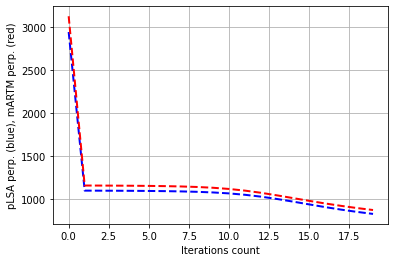

In [95]:
def print_measures(model_plsa, model_martm):

    print ('Perplexity: {0:.3f} (pLSA) vs. {1:.3f} (mARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_martm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_martm.num_phi_updates), model_martm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    
    plt.xlabel('Iterations count')
    plt.ylabel('pLSA perp. (blue), mARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_martm)